# 1) Imports

In [6]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import os

In [9]:
# Modelos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
# from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Separar/validar dados
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import preprocessing

# Redução de dimensionalidade
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Representação vetorial para imagem
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.efficientnet import (
	EfficientNetB0, EfficientNetB1,
	EfficientNetB2, EfficientNetB3,
	EfficientNetB4, EfficientNetB5,
	EfficientNetB6, EfficientNetB7
)
from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

# 2) Carregar imagens de clusters em pastas

In [128]:
percentage_test_size = 0.2
undersampling_size = 500 # -1 para não fazer undersampling

diretorio = './clusters'

In [134]:
targets = next(os.walk(diretorio))[1]

print('Targets:', *targets, sep='\n- ')

dados = []

quantia_imagens = {}

for dirname, dirpaths, filenames in os.walk(diretorio):
    for file in filenames:
        if not file.endswith('.png'):
            continue

        caminho_imagem = os.path.join(*dirname.split('\\'), file).replace('\\', '/')
        target = dirname.replace(diretorio, '').replace('\\', '')
        
        if target not in quantia_imagens:
            quantia_imagens[target] = 0
        
        if quantia_imagens[target] >= undersampling_size:
            continue

        quantia_imagens[target] += 1

        dados.append([caminho_imagem, target])
        

Targets:
- large_bowel
- null
- small_bowel
- stomach


# 3) Carregar imagens de clusters separadas por target

In [135]:
dados = np.array(dados)

np.random.shuffle(dados)
            
df_dados = pd.DataFrame(dados, columns=['image','target'])

df_dados

,image,target
0,./clusters/stomach/10_case88_day38_slice_0089.png,stomach
1,./clusters/null/0_case32_day20_slice_0087.png,null
2,./clusters/small_bowel/0_case156_day0_slice_00...,small_bowel
3,./clusters/large_bowel/0_case136_day25_slice_0...,large_bowel
4,./clusters/null/0_case33_day0_slice_0091.png,null
...,...,...
1995,./clusters/null/0_case54_day0_slice_0052.png,null
1996,./clusters/stomach/0_case121_day0_slice_0126.png,stomach
1997,./clusters/null/0_case131_day21_slice_0063.png,null
1998,./clusters/small_bowel/0_case119_day0_slice_01...,small_bowel


stomach        500
null           500
small_bowel    500
large_bowel    500
Name: target, dtype: int64


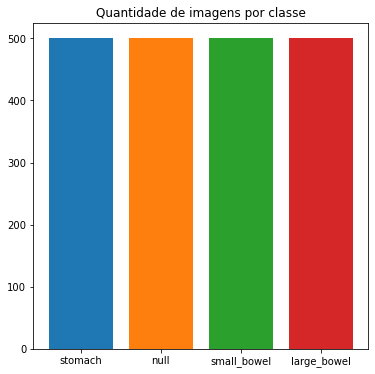

In [136]:
vc = df_dados['target'].value_counts()

print(vc)

plt.figure(figsize=(6,6))

for i in range(len(targets)):
	target = targets[i]
	chave, valor = vc.keys()[i], vc.values[i]
	plt.bar(chave, valor)

plt.title('Quantidade de imagens por classe')
plt.show()

In [109]:
def getEmbedder():
    # return EfficientNetB0(weights='imagenet', include_top=False)
    # return EfficientNetB2(weights='imagenet', include_top=False)
    return EfficientNetB3(weights='imagenet', include_top=False)
    # return EfficientNetB4(weights='imagenet', include_top=False)
    # return EfficientNetB7(weights='imagenet', include_top=False)
    # return InceptionV3(weights='imagenet', include_top=False)

In [137]:
largura, altura = 150, 150

def embedding(embedder,img_path):
    img = image.load_img(img_path, target_size=(altura, largura))
    embed = image.img_to_array(img)
    embed = np.expand_dims(embed, axis=0)
    # embed = preprocess_input(embed)

    features = embedder.predict(embed)

    return features[0][0][0]

embedder = getEmbedder()

In [138]:
target = df_dados['target'].array

array_features = []
for x in dados:
    array_features.append(embedding(embedder,x[0]))

scaler = preprocessing.StandardScaler()

array_features = scaler.fit_transform(array_features)

df_features = pd.DataFrame(array_features)

df_features

,0,1,2,3,4,5,6,7,8,9,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
0,1.133641,-0.593402,-0.607146,0.647748,0.279626,0.397096,2.588698,-0.581534,-0.707867,-0.720224,...,-0.335527,0.441167,-0.578076,-0.355153,-0.678573,-0.418892,-0.243617,0.844741,-0.719451,-0.402383
1,-0.721724,-0.728404,-0.458404,-0.542634,-1.084072,-1.002846,-0.644696,-0.575818,-0.018768,1.636842,...,-0.032545,-0.609996,-0.516849,0.213608,-0.681363,0.163193,-0.348217,-0.949467,1.243596,0.545004
2,0.320165,-0.282110,-0.145797,0.279512,1.225756,2.603105,-0.624884,0.580035,-0.692548,-0.298957,...,1.042954,0.536379,0.680163,-0.339681,0.093818,0.076933,-0.580035,-0.283830,0.885582,-0.672274
3,-0.791673,-0.775910,-0.336974,-0.552151,-0.201068,-0.966684,0.368460,-0.573567,-0.696566,-0.673440,...,-0.520723,-0.289471,-0.440015,-0.067888,-0.492364,-0.440619,-0.374722,1.418437,0.202436,-0.690299
4,0.172677,0.145607,-0.504959,-0.492553,-1.134075,-1.009663,-1.131584,-0.569188,-0.495185,-0.679267,...,0.445075,-0.596480,-0.571504,-0.435469,-0.913982,-0.443591,2.462142,0.464325,0.142946,-0.692713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-0.547372,0.001512,-0.539267,-0.552091,-1.255898,-0.897193,-0.360003,-0.578023,0.432998,0.963457,...,-0.135170,-0.710030,-0.586323,0.314071,-0.878032,0.285834,-0.370933,-1.144696,1.376766,2.096394
1996,-0.458782,-0.238680,-0.593084,-0.347082,-0.272297,-0.772467,0.060321,-0.437031,-0.720316,-0.724086,...,0.110787,-0.575955,-0.326382,-0.378671,-0.680980,-0.142190,-0.546975,0.410945,0.193153,-0.695425
1997,0.938013,-0.857798,0.069110,-0.407708,-0.406005,0.905633,0.623049,-0.344244,-0.615827,-0.559891,...,-0.401521,-0.036434,-0.596594,-0.206680,-0.762813,-0.451491,-0.579668,-0.676982,0.894105,-0.430385
1998,-0.232833,1.233884,-0.197361,0.142794,-0.827843,-0.706252,0.389142,-0.391065,-0.231203,-0.582770,...,0.514264,-0.635417,-0.389842,-0.399861,0.238662,-0.048486,0.440557,-0.774227,0.055703,1.764911


# 4) Reduzir dimensionalidade

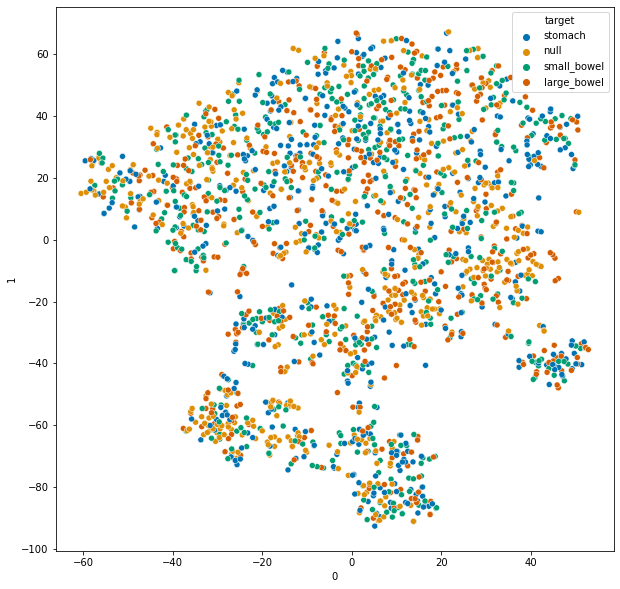

In [139]:
model = TSNE(
	n_components=2,
	# learning_rate='auto',
	init='random',
	perplexity=15
)

array_red = model.fit_transform(df_features) 

df_tsne = pd.DataFrame(array_red)

df_tsne['target'] = target

plt.rcParams['figure.figsize'] = [10, 10]

sns.scatterplot(data=df_tsne, x=df_tsne[0], y=df_tsne[1], hue=df_tsne['target'], palette="colorblind")

plt.show()

# 5) Treinamento de modelo/rede

In [142]:
def getModel():
    # return RandomForestClassifier(n_jobs=-1)
    return LogisticRegression(n_jobs=-1, max_iter=500)
    # return KNeighborsClassifier(n_neighbors=3,n_jobs=-1)
    # return XGBClassifier()
    # return SGDClassifier(n_jobs=-1,early_stopping=True,validation_fraction=0.05)
		
		# TODO Rede aqui ao invés de modelo

## Verificação de score

In [143]:
scores = cross_val_score(getModel(), df_features.values, target, cv=10)

np.mean(scores)

c:\tools\Anaconda3\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:432: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\tools\Anaconda3\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:432: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

0.2835

## Matriz de confusão

c:\tools\Anaconda3\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:432: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\tools\Anaconda3\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:432: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

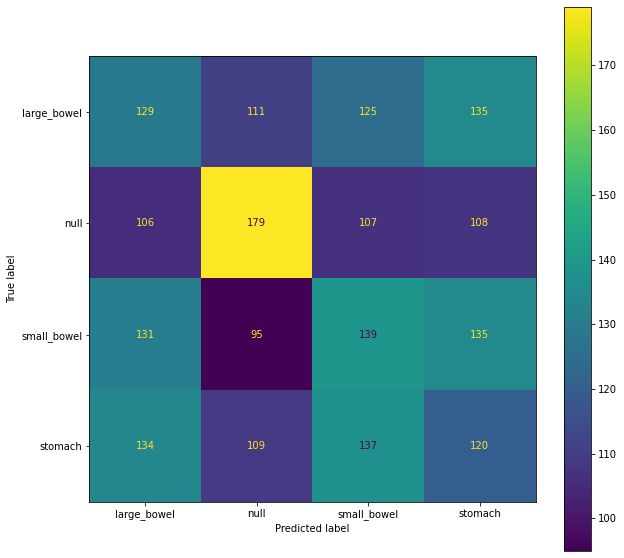

In [145]:
predicoes = cross_val_predict(getModel(), df_features.values,target, cv=10)

cm = confusion_matrix(target, predicoes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=targets)
disp.plot()

plt.show()